bone_marrow.h5ad already exists, skipping download.
Dataset loaded:
AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
   

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Preprocessing complete.
computing PCA
    with n_comps=50
    finished (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Dimensionality reduction and clustering complete.
ensembl_mapping.txt already exists, skipping download.
Ensembl mapping loaded.
Markers mapped to Ensembl IDs.
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', so

/tmp/ipython-input-597246287.py:171: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_centers = adata.obs.groupby('cell_type').apply(


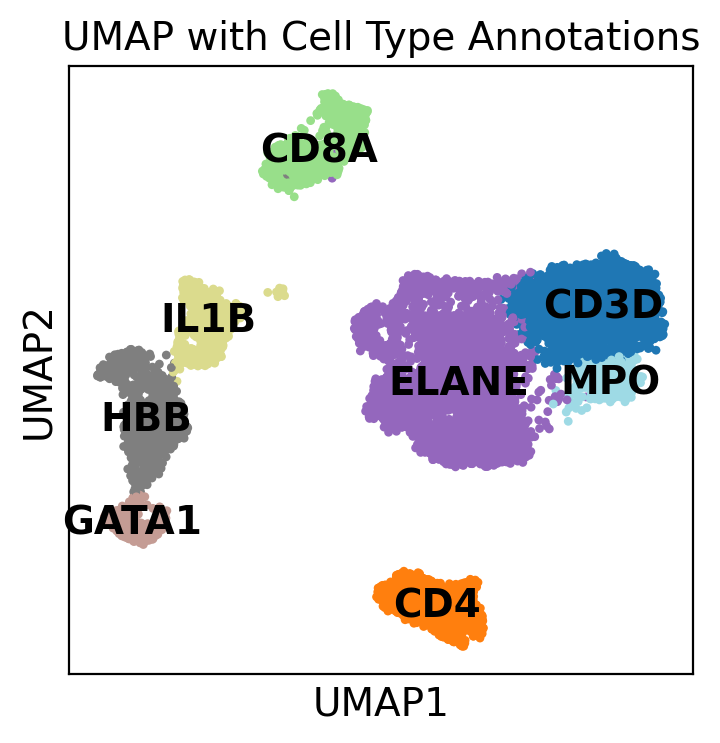

UMAP plotted with cell type labels.


In [28]:
# ==========================
# HackBio Stage 2: Single‑Cell RNA‑Seq Pipeline
# Dataset: Bone Marrow (.h5ad)
# Tools: Scanpy + Decoupler + PanglaoDB
# Author: Micaiah Adedeji Adeoluwa
# ==========================

import os
import urllib.request
import pandas as pd
import numpy as np
import urllib.parse

# -------------------------
# Install dependencies
# -------------------------
try:
    import scanpy as sc
except ImportError:
    !pip install scanpy
    import scanpy as sc

try:
    import decoupler as dc
except ImportError:
    !pip install --upgrade --force-reinstall decoupler
    import decoupler as dc

try:
    import igraph
except ImportError:
    !pip install python-igraph

try:
    import leidenalg
except ImportError:
    !pip install leidenalg

from pptx import Presentation
from pptx.util import Inches, Pt
import matplotlib.pyplot as plt

# -------------------------
# Optional plotting settings
# -------------------------
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

# ==========================
# Function Definitions
# ==========================

def download_file(url, out_file):
    """Download file from url if it doesn't exist."""
    if not os.path.exists(out_file):
        print(f"Downloading {out_file}...")
        urllib.request.urlretrieve(url, out_file)
        print(f"Download complete: {out_file}")
    else:
        print(f"{out_file} already exists, skipping download.")

def load_h5ad(file_path):
    """Load AnnData object and print summary."""
    adata = sc.read_h5ad(file_path)
    print("Dataset loaded:")
    print(adata)
    return adata

def preprocess_adata(adata, min_genes=200, min_cells=3):
    """Perform QC, filtering, normalization, log1p, HVG selection, and scaling."""
    # Filter low-quality cells and genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # Identify mitochondrial genes and calculate QC metrics
    if any(adata.var_names.str.startswith("MT-")):
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
        adata = adata[adata.obs.n_genes_by_counts < 5000, :]
        adata = adata[adata.obs.pct_counts_mt < 10, :]

    # Normalize total counts per cell, log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.scale(adata, max_value=10)
    print("Preprocessing complete.")
    return adata

def reduce_dimensions_and_cluster(adata, n_neighbors=10, n_pcs=40, leiden_resolution=0.5):
    """Compute PCA, neighbors, UMAP, and Leiden clustering."""
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=leiden_resolution)
    print("Dimensionality reduction and clustering complete.")
    return adata

def download_ensembl_mapping(mapping_file="ensembl_mapping.txt"):
    """Download Ensembl ID to gene symbol mapping from BioMart."""
    biomart_xml_query = """"""
    biomart_url = "http://www.ensembl.org/biomart/martservice?query=" + urllib.parse.quote(biomart_xml_query)
    download_file(biomart_url, mapping_file)
    ensembl_var = pd.read_csv(mapping_file, header=None)
    ensembl_var.columns = ["ensembl_gene_id", "gene_name"]
    print("Ensembl mapping loaded.")
    return ensembl_var

def get_panglao_markers(ensembl_var):
    """Get PanglaoDB markers and map to Ensembl IDs."""
    markers = dc.op.resource(name="PanglaoDB", organism="human")
    markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
    markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
    markers = markers[["source", "target"]]
    # Map to Ensembl
    markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
    markers = markers.drop(columns=["target", "gene_name"])
    markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]
    markers = markers.rename(columns={"ensembl_gene_id": "target"})
    markers = markers[["source", "target"]].dropna()
    print("Markers mapped to Ensembl IDs.")
    return markers

def rank_genes_and_key_marker_expression(adata, ensembl_var):
    """Rank top genes per cluster and compute key lineage marker expression."""
    sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", pts=True)
    rg = adata.uns["rank_genes_groups"]
    # Print top 8 markers per cluster
    for g in adata.obs["leiden"].cat.categories:
        names = rg["names"][g][:8]
        print(f"Cluster {g} top markers: {', '.join(names)}")

    # Key lineage markers (evidence-driven selection)
    key_markers = [
        "CD34","GATA1","KLF1","HBB","MPO","ELANE","CSF1R","IL1B",
        "CD3D","CD4","CD8A","MS4A1","CD19","SDC1","MKI67","PF4",
        "PPBP","GZMB","PRF1","NKG7"
    ]
    key_markers_ensembl = ensembl_var[ensembl_var["gene_name"].isin(key_markers)]["ensembl_gene_id"].tolist()
    markers_present = [m for m in key_markers_ensembl if m in adata.var_names]

    expr = pd.DataFrame(index=adata.obs["leiden"].cat.categories, columns=markers_present, dtype=float)
    for cl in expr.index:
        cells = adata.obs_names[adata.obs["leiden"]==cl]
        expr.loc[cl] = adata[cells, markers_present].X.toarray().mean(axis=0) \
            if hasattr(adata.X, "toarray") else adata[cells, markers_present].X.mean(axis=0)
    print("Key lineage marker expression per cluster:\n", expr.round(3))
    return expr, markers_present, key_markers

def assign_cell_types(adata, key_markers_ensembl, key_markers_names):
    """Assign cell types to clusters automatically based on marker expression."""
    cluster_to_celltype = {}
    for cl in adata.obs['leiden'].cat.categories:
        cells = adata.obs_names[adata.obs['leiden'] == cl]
        expr = adata[cells, key_markers_ensembl].X.toarray().mean(axis=0) \
            if hasattr(adata.X, "toarray") else adata[cells, key_markers_ensembl].X.mean(axis=0)
        # Assign the marker with the highest mean expression
        max_idx = np.argmax(expr)
        cluster_to_celltype[cl] = key_markers_names[max_idx]
    adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)
    print("Cell types assigned to clusters based on marker expression.")
    return adata

def plot_umap_with_cell_types(adata):
    """Plot UMAP with readable cell type labels."""
    # Compute cluster centers
    umap_coords = adata.obsm['X_umap']
    cluster_centers = adata.obs.groupby('cell_type').apply(
        lambda x: umap_coords[adata.obs.index.get_indexer(x.index)].mean(axis=0)
    )

    sc.pl.umap(adata, color='cell_type', legend_loc='on data', size=40, palette='tab20', title="UMAP with Cell Type Annotations", show=True)
    print("UMAP plotted with cell type labels.")

# ==========================
# Main Workflow
# ==========================

# 1. Download dataset
download_file("https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad", "bone_marrow.h5ad")

# 2. Load
adata = load_h5ad("bone_marrow.h5ad")

# 3. Preprocess
adata = preprocess_adata(adata)

# 4. Dimensionality reduction & clustering
adata = reduce_dimensions_and_cluster(adata)

# 5. Ensembl mapping
ensembl_var = download_ensembl_mapping()

# 6. PanglaoDB markers
markers = get_panglao_markers(ensembl_var)

# 7. Rank genes & key marker expression
key_expr, key_markers_ensembl, key_markers_names = rank_genes_and_key_marker_expression(adata, ensembl_var)

# 8. Assign cell types to clusters
adata = assign_cell_types(adata, key_markers_ensembl, key_markers_names)

# 9. Plot UMAP with cell type labels
plot_umap_with_cell_types(adata)

# 10. Save processed data
adata.write("bone_marrow_processed.h5ad")

# 11. Generate LinkedIn carousel (optional)
# save_linkedin_carousel(adata)